# Putting things together 2

Here we will define a cell model with multiple sections and create a network model.

## Planning how to wire cells

In [1]:
%%bash 
pip install networkx

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

We begin with how many cells are in the network.

In [3]:
Ncells = 500                    # Number of cells
Nexc = int((Ncells/5)*4)         # Excitatory cells = 80%
Ninh = int(Ncells/5)             # Inhibitory cells = 20%
nexcpre = int(Nexc*0.1)          # Presynaptic excitatory cells for each neuron = 10% of excitatory cells
ninhpre = int(Ninh*0.1)          # Presynaptic inhibitory cells for each neuron = 10% of inhibitory cells

print('Ncells =', Ncells, '\nNexc =', Nexc, '\nNinh =', Ninh, '\nnexcpre =',nexcpre, '\nninhpre =', ninhpre)

Ncells = 500 
Nexc = 400 
Ninh = 100 
nexcpre = 40 
ninhpre = 10


Here we first specify an anatomical basis of the network, which is defined by a directional graph structure, containing nodes for cells and edges for cell-to-cell connections.

In [5]:
G = nx.DiGraph()

In [6]:
for i in range(Ncells):
    if i<Nexc:
        G.add_node(i, cell_type='E', rho=200, c=10)
    else:
        G.add_node(i, cell_type='I', rho=80, c=10)

In [7]:
for i in range(Ncells):
    
    # Choose nexcpre cells from Nexc excitatory cells
    exc_pre = np.random.randint(0, Nexc, nexcpre)
    # Choose ninhpre cells from Ninh inhibitory cells
    inh_pre = np.random.randint(Nexc, Ncells, ninhpre)

    for k in exc_pre:
        if i!=k:  # No self-connection
            if k in G[i]:
                G[i][k]['weight'] +=1
            else:
                G.add_edge(i, k, weight=1)
            
    for k in inh_pre:
        if i!=k:  # No self-connection
            if k in G[i]:
                G[i][k]['weight'] +=1
            else:
                G.add_edge(i, k, weight=1)

Let's check the nodes and connections 

In [2]:
for i in G.nodes:
    print(i, G.nodes[i]['cell_type'])

0 E
1 E
2 E
3 E
4 E
5 E
6 E
7 E
8 E
9 E
10 E
11 E
12 E
13 E
14 E
15 E
16 E
17 E
18 E
19 E
20 E
21 E
22 E
23 E
24 E
25 E
26 E
27 E
28 E
29 E
30 E
31 E
32 E
33 E
34 E
35 E
36 E
37 E
38 E
39 E
40 E
41 E
42 E
43 E
44 E
45 E
46 E
47 E
48 E
49 E
50 E
51 E
52 E
53 E
54 E
55 E
56 E
57 E
58 E
59 E
60 E
61 E
62 E
63 E
64 E
65 E
66 E
67 E
68 E
69 E
70 E
71 E
72 E
73 E
74 E
75 E
76 E
77 E
78 E
79 E
80 E
81 E
82 E
83 E
84 E
85 E
86 E
87 E
88 E
89 E
90 E
91 E
92 E
93 E
94 E
95 E
96 E
97 E
98 E
99 E
100 E
101 E
102 E
103 E
104 E
105 E
106 E
107 E
108 E
109 E
110 E
111 E
112 E
113 E
114 E
115 E
116 E
117 E
118 E
119 E
120 E
121 E
122 E
123 E
124 E
125 E
126 E
127 E
128 E
129 E
130 E
131 E
132 E
133 E
134 E
135 E
136 E
137 E
138 E
139 E
140 E
141 E
142 E
143 E
144 E
145 E
146 E
147 E
148 E
149 E
150 E
151 E
152 E
153 E
154 E
155 E
156 E
157 E
158 E
159 E
160 E
161 E
162 E
163 E
164 E
165 E
166 E
167 E
168 E
169 E
170 E
171 E
172 E
173 E
174 E
175 E
176 E
177 E
178 E
179 E
180 E
181 E
182 E
183 E
184 E


In [4]:
i = 0
for k in G[i]:
    print(k, G.nodes[k]['cell_type'], G[i][k]['weight'])

181 E 1
193 E 1
279 E 1
393 E 1
108 E 1
292 E 1
276 E 1
214 E 1
247 E 1
241 E 1
330 E 1
243 E 1
26 E 1
166 E 1
161 E 1
310 E 1
343 E 1
370 E 1
367 E 1
130 E 1
184 E 1
240 E 1
79 E 1
386 E 1
39 E 1
379 E 1
288 E 1
382 E 1
337 E 1
334 E 1
226 E 1
377 E 1
191 E 1
99 E 1
232 E 1
340 E 1
73 E 1
27 E 1
271 E 1
211 E 1
490 I 1
480 I 1
400 I 1
401 I 1
445 I 1
411 I 1
406 I 1
496 I 1
483 I 1
497 I 1


We can save the constructed network:

In [11]:
import pickle
with open('balanced_Mainen.pkl', 'wb') as f:
    pickle.dump(G, f)

Then, the network can be reused later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import pickle
with open('balanced_Mainen.pkl', 'rb') as f:
    G = pickle.load(f)

# i = 0
# for k in G[i]:
#     print(k, G.nodes[k]['cell_type'], G[i][k]['weight'], G[i][k]['target'])

## Building a network model after the plan

We first create neurons in the network according to the plan:

In [5]:
from neuron import h, gui, load_mechanisms
from net_manager import SerialNetManager
from cell_models import Mainen

pnm = SerialNetManager(len(G.nodes))

for i in G.nodes:
    pnm.register_cell(i, Mainen(i, rho=G.nodes[i]['rho'], c=G.nodes[i]['c']))

Then, we add brief stimuli for the cells to kickstart the network activity

In [6]:
# Kickstart stims
ext_stims = []
ext_ncs = []
for i in G.nodes:
    stim = h.NetStimFD(pnm.gid2cell[i].soma(0.5))
    stim.interval = 3
    stim.noise = 1
    stim.start = 0
    stim.duration = 7
    stim.seed(i+1223)

    nc = h.NetCon(stim, pnm.gid2cell[i].synlist[1])
    nc.weight[0] = 2.5e-3
    ext_stims.append((stim, nc))

In [7]:
pnm.want_all_spikes()

h.tstop = 400
h.init()
pnm.run()

[Text(0.5, 0, 'Time (ms)'), Text(0, 0.5, 'Neuron')]

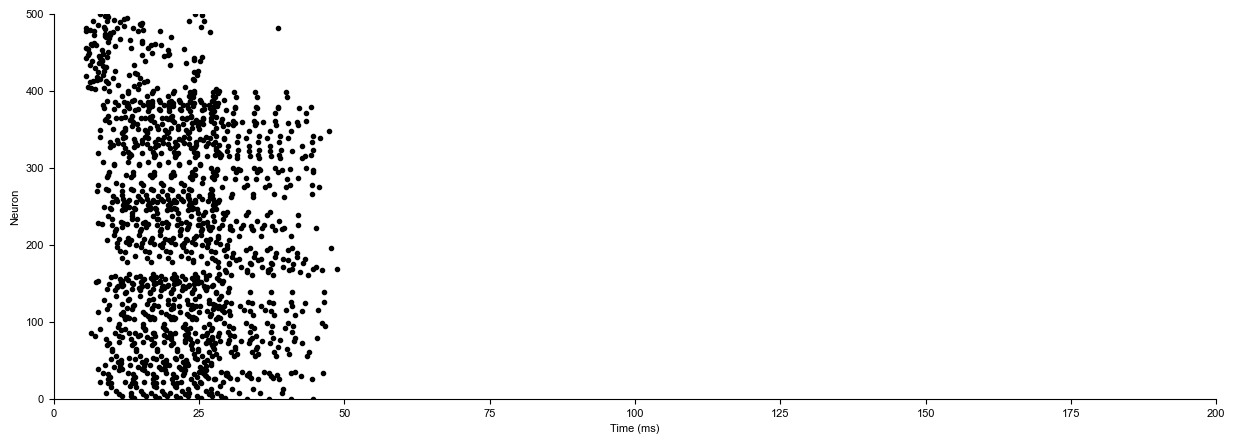

In [9]:
Ncells = len(G.nodes)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(pnm.spikevec, pnm.idvec, '.k')
ax.set(xlim=[0, 200], ylim=[0, Ncells])
ax.set(xlabel='Time (ms)', ylabel='Neuron')

Then we wire the cells for each edge in our plan.

In [10]:
gexc = 0.5e-3     # 0.5 nS initial value --- will be adjusted later
ginh = 10.*gexc   # initial value --- will be adjusted later

# Reset all NetCon's
pnm.nc_reset()

# Go around every cell
for i in G.nodes:
    for k in G[i]:
        t_delay = np.random.rand()
        if G.nodes[k]['cell_type']=='E':
            g = gexc*G[i][k]['weight']
            pnm.nc_append(k, i, 0, g, t_delay, thresh=-10)
            pnm.nc_append(k, i, 1, g, t_delay, thresh=-10)
        else:
            g = ginh*G[i][k]['weight']
            pnm.nc_append(k, i, 2, g, t_delay, thresh=-10)

Here are functions to adjuct synaptic conductances and pack the simulation results into a matrix:

In [11]:
def set_global_synaptic_conductance(gexc, ginh, G, pnm):
    for nc in pnm.netcons:
        k, i, _ = nc
        if G.nodes[k]['cell_type']=='E':
            g = gexc*G[i][k]['weight']
        else:
            g = ginh*G[i][k]['weight']
        pnm.netcons[nc].weight[0] = g

        
def repack_result(pnm, G, t_init=75):
    x = np.array([pnm.spikevec, pnm.idvec]).T
    x = x[x[:,0]>t_init,:]
    x[:,0] -= t_init
    e_or_i = np.array([G.nodes[n]['cell_type']=='E' for n in G.nodes])
    e_or_i = e_or_i[x[:,1].astype(int)]
    x = np.hstack([x, e_or_i[:,None]])
    return x

In [48]:
t_init = 75

h.tstop = t_init+1000
h.init()
pnm.run()

[Text(0.5, 0, 'Time (ms)'), Text(0, 0.5, 'Neuron'), (0.0, 1000.0)]

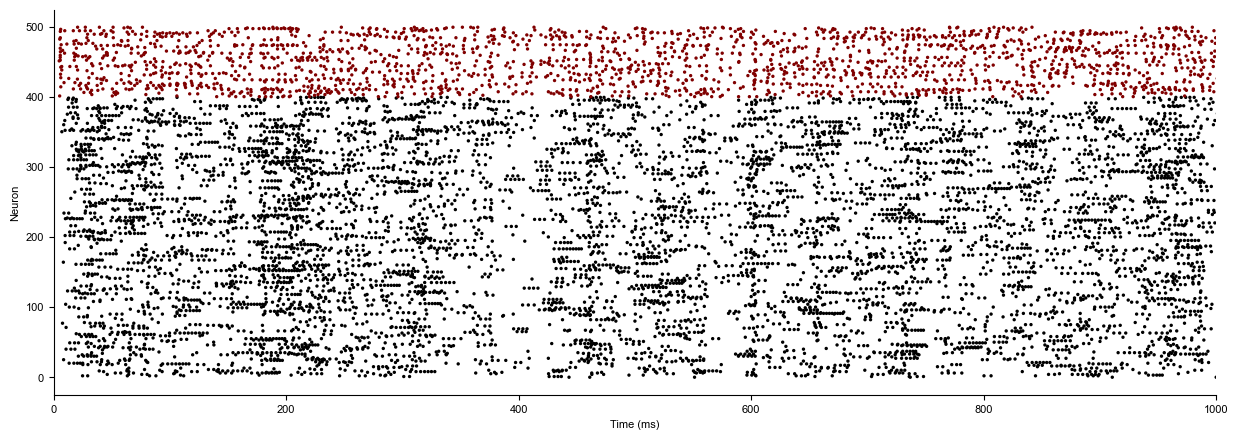

In [49]:
x = repack_result(pnm, G, t_init=0)

col = np.zeros((x.shape[0], 3));
col[x[:,2]==0,:] = [0.5,0,0]

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(x[:,0], x[:,1], 2, c=col)
ax.set(xlabel='Time (ms)', ylabel='Neuron', xlim=[0, h.tstop-75])

Let's adjust the synaptic parameters until we get stable asynchronous activity:

In [47]:
gexc=1.8e-3
set_global_synaptic_conductance(gexc, 200.*gexc, G, pnm)

Let's make a firing rate histogram averaged over all the cells first

[(0.0, 1000.0), Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'rate (Hz)')]

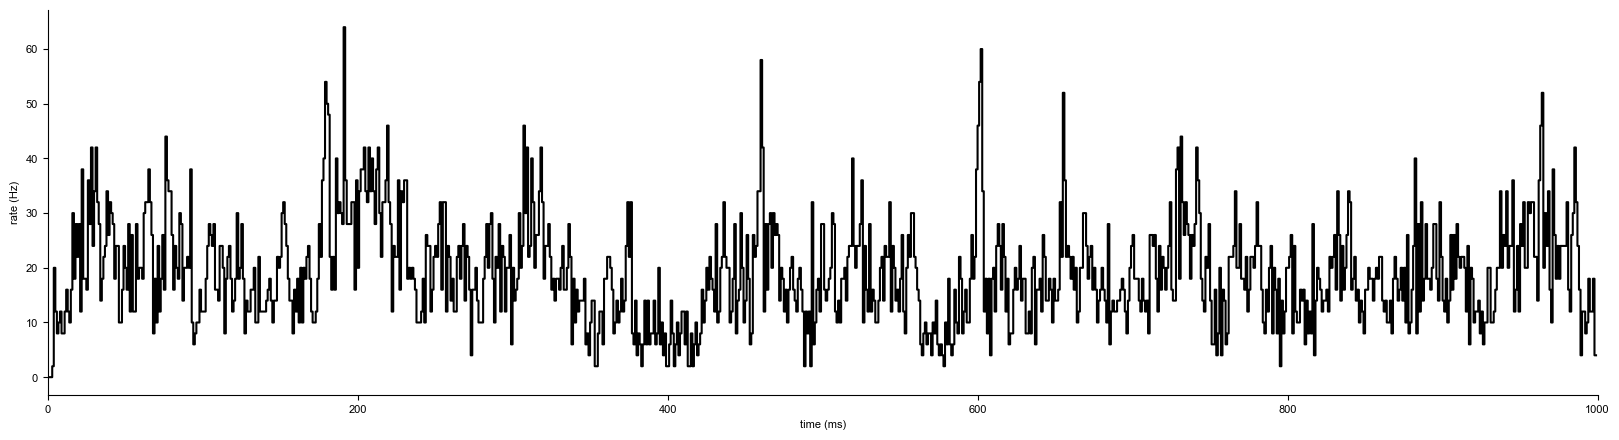

In [50]:
tstop = h.tstop-t_init
tc = np.arange(tstop+1)
spikecount_all, _ = np.histogram(x[:,0], tc)
t = tc[:-1]

_, ax = plt.subplots(figsize=(20, 5))
ax.step(t, spikecount_all/Ncells*1e3, 'k')
ax.set(xlim=[0, tstop], xlabel='time (ms)', ylabel='rate (Hz)')

We do the same for the excitatory and inhibitory population

[Text(0, 0.5, 'rate (Hz)')]

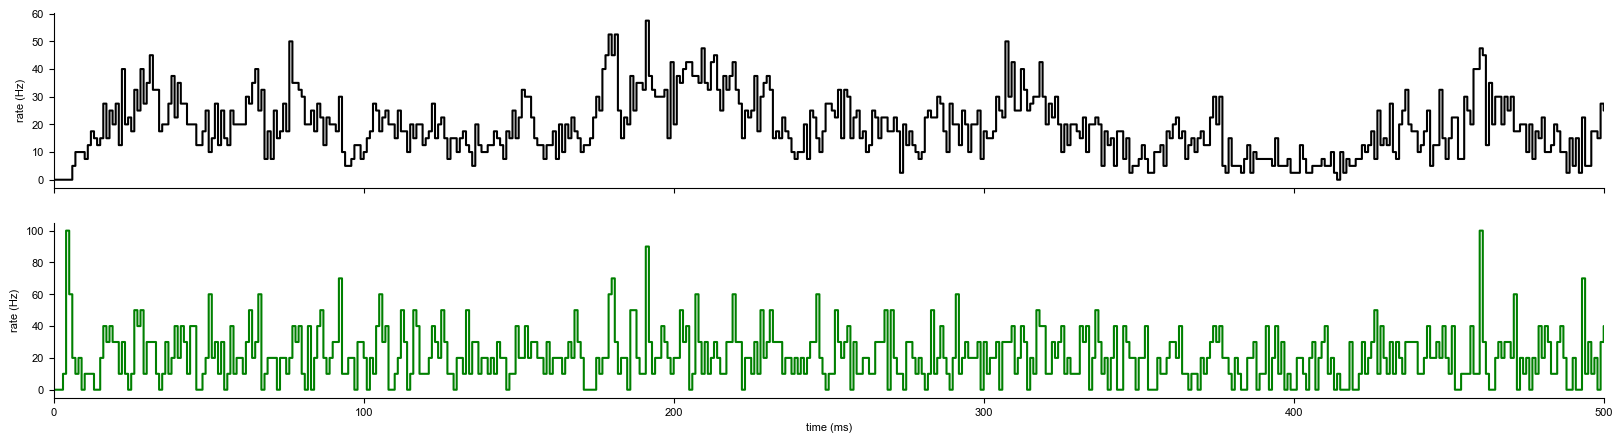

In [51]:
tc = np.arange(tstop+1)
spikecount_exc, _ = np.histogram(x[x[:,2]==1,0], tc)
spikecount_inh, _ = np.histogram(x[x[:,2]==0,0], tc)
t = tc[:-1]

Nexc = len([G.nodes[i] for i in G.nodes if G.nodes[i]['cell_type']=='E'])
Ninh = len([G.nodes[i] for i in G.nodes if G.nodes[i]['cell_type']=='I'])

_, axs = plt.subplots(figsize=(20, 5), nrows=2, sharex=True)
axs[0].step(t, spikecount_exc/Nexc*1e3, 'k')
axs[1].step(t, spikecount_inh/Ninh*1e3, 'g')
axs[1].set(xlim=[0, 500], xlabel='time (ms)', ylabel='rate (Hz)')
axs[0].set(ylabel='rate (Hz)')

Note that the E/I population activities are positively correlated.

In [52]:
np.corrcoef(spikecount_exc, spikecount_inh)

array([[1.        , 0.30414384],
       [0.30414384, 1.        ]])